In [1]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
import pandas as pd
import polars as pl
import numpy as np
import time
import glob
import sys
import os

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from utils import prepare_data

df = np.load("output.npy", allow_pickle = True).item()

data = []
for game_id in tqdm(df.keys()):
    for play_id in df[game_id].keys():
        play = np.nan_to_num(df[game_id][play_id])
        play = prepare_data(play)
        
        data.append(play)
    
data[0].shape

  0%|          | 0/136 [00:00<?, ?it/s]

(22, 22, 11)

In [3]:
start = int(len(data) * 0.7)

training_data = data[:start]
testing_data  = data[start:]

print(f"Training dataset size: {len(training_data)}")
print(f"Testing dataset size: {len(testing_data)}")

training_data[0].shape

Training dataset size: 8647
Testing dataset size: 3707


(22, 22, 11)

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader

class _RepeatSampler(object):
    def __init__(self, sampler):
        self.sampler = sampler

    def __iter__(self):
        while True:
            yield from iter(self.sampler)

class MultiEpochsDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self._DataLoader__initialized = False
        self.batch_sampler = _RepeatSampler(self.batch_sampler)
        self._DataLoader__initialized = True
        self.iterator = super().__iter__()

    def __len__(self):
        return len(self.batch_sampler.sampler)

    def __iter__(self):
        for i in range(len(self)):
            yield next(self.iterator)

class NflDataset(Dataset):
    def __init__(self, x):
        self.x = x
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        x = self.x[i]
        y = x[:, :, :4]
        return x, y
    
def collate_fn(batch):
    x = [torch.Tensor(b[0]).float() for b in batch]
    y = [torch.Tensor(b[1]).float() for b in batch]
    sorted_x = sorted(x, key = lambda x: x.shape[0], reverse = True)
    sorted_y = sorted(y, key = lambda x: x.shape[0], reverse = True)
    sequences_x = torch.nn.utils.rnn.pad_sequence(sorted_x, batch_first = True)
    sequences_y = torch.nn.utils.rnn.pad_sequence(sorted_y, batch_first = True)
    lengths = [len(a) for a in sorted_x]
    return sequences_x, sequences_y, lengths


In [5]:
LOG_EVERY = 25
BATCH_SIZE = 32
EPOCHS = 30
LR = 0.0003
DEVICE = "cuda"

In [6]:
from model import TrajectoryModel

model = TrajectoryModel().to(DEVICE)

In [7]:
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim 
import torch.nn as nn
import torch

train_dataset = NflDataset(x = training_data)
train_dataloader = MultiEpochsDataLoader(
    train_dataset, 
    batch_size = BATCH_SIZE,
    collate_fn = collate_fn,
    pin_memory = True,
    drop_last = True,
    shuffle = True,
    num_workers = 1
)

test_dataset = NflDataset(x = testing_data)
test_dataloader = MultiEpochsDataLoader(
    test_dataset, 
    batch_size = BATCH_SIZE,
    collate_fn = collate_fn,
    pin_memory = True,
    drop_last = True,
    shuffle = True,
    num_workers = 1
)

optimizer = optim.Adam(model.parameters(), lr = LR)
loss_function = nn.MSELoss()

ITERS = len(train_dataloader)
delimiter = " | "

testing_direction_loss_values = [] 
testing_trajectory_loss_values = [] 
training_direction_loss_values = [] 
training_trajectory_loss_values = [] 

total_time = time.time()
for epoch in range(1, EPOCHS + 1):
    epoch_time = time.time()
    
    epoch_testing_direction_loss_values = [] 
    epoch_testing_trajectory_loss_values = [] 
    epoch_training_direction_loss_values = [] 
    epoch_training_trajectory_loss_values = [] 
    
    model.train(True)
    for step, (x, y, seq_lens) in enumerate(train_dataloader, 1):
        step_time = time.time()
        
        batch, seq_len, n_players, n_features = x.shape
        batch, seq_len, n_players, n_features = y.shape
        
        x = x.to(DEVICE, non_blocking = True).float()
        y = y.to(DEVICE, non_blocking = True).float()
        
        # Reduces the number of memory operations. 
        for param in model.parameters():
            param.grad = None
        
        (traj, direction), _ = model(x.clone(), seq_lens)
        
        dir_loss = 0
        traj_loss = 0
        for i in range(len(seq_lens)):  
            dir_loss = dir_loss + loss_function(direction[i, :seq_lens[i]-1], y[i, 1:seq_lens[i], :, 2:4]) / 1_000
            traj_loss = traj_loss + loss_function(traj[i, :seq_lens[i]-1],  y[i, 1:seq_lens[i], :, :2]) 

        dir_loss = dir_loss / len(seq_lens)
        traj_loss = traj_loss / len(seq_lens)
        loss = dir_loss + traj_loss
        
        loss.backward()
        optimizer.step()
        
        epoch_training_direction_loss_values.append(dir_loss.item() * 1_000)
        epoch_training_trajectory_loss_values.append(traj_loss.item())

        if step % LOG_EVERY == 0:
            curr_time = time.time()
            print(delimiter.join([
                f"Epoch: [{epoch:>{len(str(EPOCHS))}}/{EPOCHS}]", 
                f"Step: [{step:>{len(str(ITERS))}}/{ITERS}]",
                f"Step Time: {curr_time - step_time:6.4f}",
                f"Total Time: {curr_time - total_time:8.4f}",
                f"Traj Loss: {traj_loss.item():.10f}",
                f"Dir Loss: {dir_loss.item() * 1_000:.10f}",
            ]))

    print("Starting testing")
    model.eval()
    with torch.no_grad():
        for step, (x, y, seq_lens) in enumerate(test_dataloader, 1):
            step_time = time.time()

            batch, seq_len, n_players, n_features = x.shape
            batch, seq_len, n_players, n_features = y.shape

            x = x.to(DEVICE, non_blocking = True).float()
            y = y.to(DEVICE, non_blocking = True).float()

            (traj, direction), _ = model(x, seq_lens)

            dir_loss = 0
            traj_loss = 0
            for i in range(len(seq_lens)):  
                dir_loss = dir_loss + loss_function(direction[i, :seq_lens[i]-1], y[i, 1:seq_lens[i], :, 2:4]) / 1_000
                traj_loss = traj_loss + loss_function(traj[i, :seq_lens[i]-1],  y[i, 1:seq_lens[i], :, :2]) 

            dir_loss = dir_loss / len(seq_lens)
            traj_loss = traj_loss / len(seq_lens)
            loss = dir_loss + traj_loss

            epoch_testing_direction_loss_values.append(dir_loss.item() * 1_000)
            epoch_testing_trajectory_loss_values.append(traj_loss.item())
            
    print("Finished testing")
    
    testing_direction_loss_values.append(epoch_testing_direction_loss_values)
    testing_trajectory_loss_values.append(epoch_testing_trajectory_loss_values)
    training_direction_loss_values.append(epoch_training_direction_loss_values)
    training_trajectory_loss_values.append(epoch_training_trajectory_loss_values)


Epoch: [ 1/30] | Step: [ 25/270] | Step Time: 0.0558 | Total Time:   1.6095 | Traj Loss: 0.0002382702 | Dir Loss: 0.4750902008
Epoch: [ 1/30] | Step: [ 50/270] | Step Time: 0.1005 | Total Time:   3.1256 | Traj Loss: 0.0000463848 | Dir Loss: 0.4437452299
Epoch: [ 1/30] | Step: [ 75/270] | Step Time: 0.0605 | Total Time:   4.6519 | Traj Loss: 0.0000411792 | Dir Loss: 0.4348351504
Epoch: [ 1/30] | Step: [100/270] | Step Time: 0.0577 | Total Time:   6.2030 | Traj Loss: 0.0000365466 | Dir Loss: 0.3821949940
Epoch: [ 1/30] | Step: [125/270] | Step Time: 0.0663 | Total Time:   7.7667 | Traj Loss: 0.0000377720 | Dir Loss: 0.2730561537
Epoch: [ 1/30] | Step: [150/270] | Step Time: 0.0663 | Total Time:   9.2926 | Traj Loss: 0.0000384019 | Dir Loss: 0.2206135687
Epoch: [ 1/30] | Step: [175/270] | Step Time: 0.0618 | Total Time:  10.7874 | Traj Loss: 0.0000451220 | Dir Loss: 0.1720715081
Epoch: [ 1/30] | Step: [200/270] | Step Time: 0.0683 | Total Time:  12.3890 | Traj Loss: 0.0000370873 | Dir Los

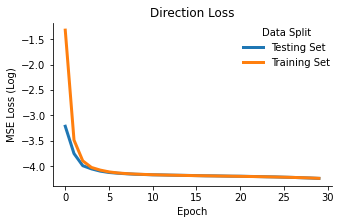

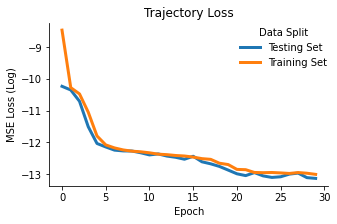

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (5, 3))
ax.plot(np.log(np.array(testing_direction_loss_values).mean(axis = 1)), label = "Testing Set", linewidth = 3)
ax.plot(np.log(np.array(training_direction_loss_values).mean(axis = 1)), label = "Training Set", linewidth = 3)
ax.set_title("Direction Loss")
ax.set_ylabel("MSE Loss (Log)")
ax.set_xlabel("Epoch")
plt.legend(title = "Data Split", loc = "center left", bbox_to_anchor = (0.65, 0.85), frameon = False)
sns.despine()
#plt.savefig(f"direction_loss_split_{split}.png", facecolor = "white", bbox_inches = "tight")
plt.show()

fig, ax = plt.subplots(1, 1, figsize = (5, 3))
ax.plot(np.log(np.array(testing_trajectory_loss_values).mean(axis = 1)), label = "Testing Set", linewidth = 3)
ax.plot(np.log(np.array(training_trajectory_loss_values).mean(axis = 1)), label = "Training Set", linewidth = 3)
ax.set_title("Trajectory Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE Loss (Log)")
plt.legend(title = "Data Split", loc = "center left", bbox_to_anchor = (0.65, 0.85), frameon = False)
sns.despine()
#plt.savefig(f"trajectory_loss_split_{split}.png", facecolor = "white", bbox_inches = "tight")
plt.show()

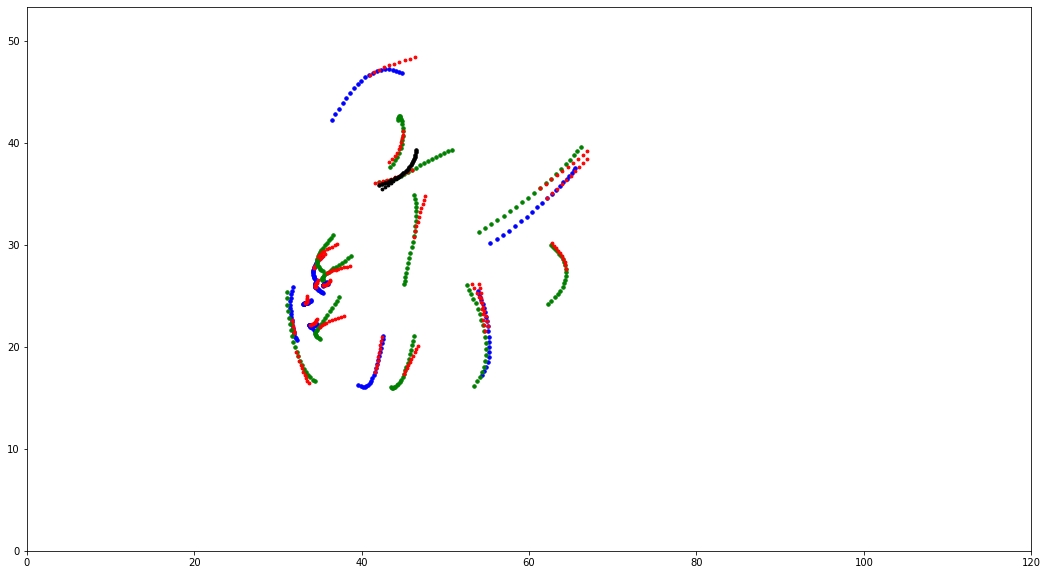

In [17]:
from model_api import TrajectoryAPI
from utils import convert_output

xmax = 120
ymax = 53.3
xmid = xmax / 2
ymid = ymax / 2

def inference(model, data):
    model_api = TrajectoryAPI(model)

    # Split the data in half, then evaluate on the second half.
    l, n, _ = data.shape
    x = data[:l//2].copy()
    pred = model_api.predict(x, l//2)
    x, y, _, _ = convert_output(pred)
    
    plt.figure(figsize = (18, 10))
    plt.xlim([0, 120])
    plt.ylim([0, 53.3])
    
    for player in range(22):
        if np.any(data[:, player, -1] > 0.5): # Ball carrier
            plt.scatter(
                x = (data[:, player, 0] * xmid) + xmid,
                y = (data[:, player, 1] * ymid) + ymid,
                color = "black",
                s = 12
            )
            plt.scatter(
                x = x[:, player],
                y = y[:, player],
                color = "black",
                s = 8
            )
        elif np.any(data[:, player, -2] > 0.5): # Defense
            plt.scatter(
                x = (data[:, player, 0] * xmid) + xmid,
                y = (data[:, player, 1] * ymid) + ymid,
                color = "green",
                s = 12
            )
            plt.scatter(
                x = x[:, player],
                y = y[:, player],
                color = "red",
                s = 8
            )
        else: # Offense
            plt.scatter(
                x = (data[:, player, 0] * xmid) + xmid,
                y = (data[:, player, 1] * ymid) + ymid,
                color = "blue",
                s = 12
            )
            plt.scatter(
                x = x[:, player],
                y = y[:, player],
                color = "red",
                s = 8
            )
            
    plt.show()
    
inference(model, testing_data[0])

In [18]:
from utils import save_model

save_model("model.pt", model)